In [1]:
import numpy as np
import qutip as qt
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import csvkit as csv
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':20})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
options = qt.Options()
options.nsteps = 100000
#print(options)

/tmp/ipykernel_12035/2651607421.py:14: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [2]:
# Constants
h = 2*np.pi 
hbar = 1 #qutip inherently uses hbar=1
hbar_eV = 6.58e-16*1e12 #hbar/eV = 6.58e-4 ps, for conversion purposes. 
c = 3e8*1e-10 #cm/ps
D = 0.0208e-7 # e*cm [Debye]

In [3]:
N = 500 #number of datapoints for rabi frequencies and chirps

pulse_duration =  10 #ps 

energy_splitting =  5 # eV, approximately 243nm in wavelength
omega0 = energy_splitting / hbar # radians eV/hbar
dipole_moment = 1*D # Debye, [e cm]

binwidth = 2*np.pi/omega0*100 # time of n periods of oscillation in hbar/eV 
endTime = 2*pulse_duration
N_bins = int(endTime/(binwidth*hbar_eV)) 

#chosen to be 2 time the pulse duration to ensure that the amplitude of the laserfield goes to zero.
tlist = np.linspace(0,endTime,N_bins)
tshift = endTime*0.5
tlist_shift = np.full(N_bins,tshift)
rabi0_max = 2

rabi0_arr = np.linspace(0.01,rabi0_max+0.1,N)


envelope = lambda t: np.exp(-4*np.log(2)*(t-tshift)**2/(pulse_duration**2))
# period for 5eV energy carrier is 8.4e-4 ps, calculated by hand.
print("binwidth = {:.5f} ps, number of bins: {}".format(binwidth*hbar_eV, N_bins))

binwidth = 0.08269 ps, number of bins: 241


In [4]:
# setting up operators for QuTiP simulations
rank = 2
kets = [qt.basis(2,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]
c_ops =[]
psi0 = qt.fock(2,0)

In [5]:
def simulate(omega0):    
    for i in range(N):
            rabi = lambda t, args: rabi0_arr[i] * envelope(t)      
            H_transition = hbar*0.5*qt.sigmax()
            H = [[H_transition,rabi]]
            #units of eps0? dipole is e cm, we want eV. so eps0 is V/cm
            # we want units of frequency, not eV. so eps is in units of 1/(e cm ps)
            result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs,options=options)

            final_pops[i] = result.expect[1][-1]
            #print(i)
    return final_pops

In [7]:
final_pops = np.zeros(N)
final_pops = simulate(omega0)

final_pop=0.9999, with rabi0=2pi(48 GHz)


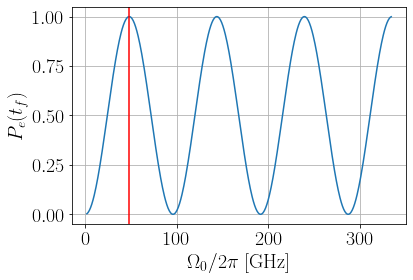

In [9]:
idx = 69
rabi0 = rabi0_arr[idx]
print("final_pop={:.4f}, with rabi0=2pi({:.0f} GHz)".format(final_pops[idx], rabi0*1e3/(2*np.pi)))


plt.plot(rabi0_arr/(2*np.pi)*1e3,final_pops)

plt.axvline(rabi0/(2*np.pi)*1e3,color='r')

#plt.title(r"")
plt.grid()
plt.xlabel(r"$\Omega_0/2\pi$ [GHz]")
plt.ylabel(r"$P_e(t_f)$")
#plt.xlim(0,1)
plt.savefig("./figures/report2/pi_solutions",bbox_inches="tight")
plt.show()

In [8]:
#rabi0 = 2*np.pi*10*c # THz
#E0 = rabi0*hbar/dipole_moment*hbar_eV
#print(E0,rabi0)

We find that the first $\pi$-solution happens when $\Omega_0\approx 0.300\mathrm{THz}$. Now double check rabi oscillations for both a constant envelope and also for a Gaussian envelope.

In [10]:
#E0=140140140 # V/cm
#print(E0)
rabi0 = 0.3 #THz
#rabi_freq = E0*dipole_moment/hbar/hbar_eV # radians THz
# period is 5 orders of magnitude too small. Not multiplying by 2pi gives the right number
# to get correct period, rabi0 needs to be 0.285 radians THz
period = 2*np.pi/rabi0

print("rabi0={:.5f} THz".format(rabi0))
print("period={:.5f} ps ".format(period))

tlist = np.linspace(0,2*endTime,N_bins)
rabi = lambda t, args: rabi0 * krotov.shapes.flattop(t, t_start=0.0, t_stop=8*pulse_duration,t_rise=0.01,func="blackman")      
H_transition = 0.5*qt.sigmax()
H = [[H_transition,rabi]]

result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)



rabi0=0.30000 THz
period=20.94395 ps 


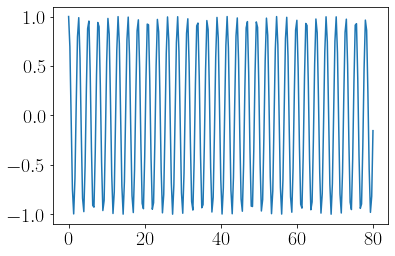

In [10]:
#Note: Make sure the binwidth is smaller than half a carrier period
carrier = lambda t: np.cos(omega0/hbar_eV*t)
plt.plot(tlist, [carrier(t) for t in tlist])

#plt.xlim(0,1)
plt.show()

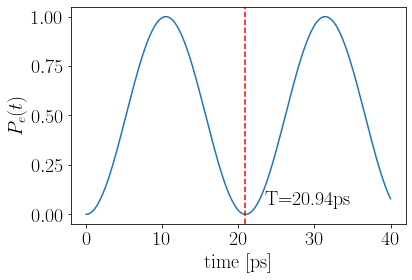

In [11]:

plt.plot(tlist,result.expect[1])
plt.xlabel("time [ps]")
plt.ylabel(r"$P_e(t)$")
plt.axvline(20.94,color='r',ls="dashed")
plt.text(23.5,0.05,r"T=20.94ps")
plt.savefig("./figures/report2/rabi_oscillations",bbox_inches="tight")
plt.show()

In [13]:
rabi0 = 0.3
tlist = np.linspace(0,endTime,N_bins)
rabi = lambda t, args: rabi0 * envelope(t)
H_transition = 0.5*qt.sigmax()
H = [[H_transition,rabi]]

result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)

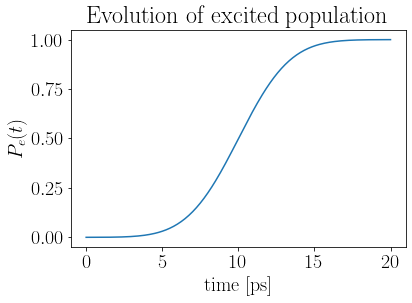

In [14]:
plt.plot(tlist,result.expect[1])
plt.title(r"Evolution of excited population")
plt.xlabel("time [ps]")
plt.ylabel(r"$P_e(t)$")
plt.savefig("./figures/report2/state_evolution",bbox_inches="tight")
plt.show()

# 2D Chirp vs rabi0 plot

In [39]:
def simulateChirp(omega0,vel=0):    
    envelope = lambda t: np.exp(-4*np.log(2)*(t-tshift)**2/(pulse_duration**2))
    for i in range(N):
        for j in range(N):
            rabi0 = Y[i][j]
            chirp = X[i][j]
            rabi = lambda t, args: rabi0 * envelope(t)      
            H_chirp = hbar*qt.Qobj([[0,0],[0,chirp]])
            H_transition = 0.5*hbar*qt.sigmax()
            H = [[H_chirp,tlist-tlist_shift],[H_transition,rabi]]

            result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)

            final_pops[i][j] = result.expect[1][-1]

        if i%5 == 0:
            print("i={}".format(i))
        
    return final_pops

In [46]:
N = 50

pulse_duration =  10 #ps 

energy_splitting =  5 # eV, approximately 243nm in wavelength
omega0 = energy_splitting / hbar # radians eV/hbar
dipole_moment = 1*D # Debye, [e cm]

binwidth = 2*np.pi/omega0*1000 # time of n periods of oscillation in hbar/eV 
#chosen to be 2 time the pulse duration to ensure that the amplitude of the laserfield goes to zero.
endTime = 2*pulse_duration
N_bins = int(endTime/(binwidth*hbar_eV)) 


tlist = np.linspace(0,endTime,N_bins)
tshift = endTime*0.5
tlist_shift = np.full(N_bins,tshift)

max_chirp = 0.3
rabi0_max = 2

chirps_arr = np.linspace(-max_chirp,max_chirp,N)  # linear temporal chirp
rabi0_arr = np.linspace(0.1,rabi0_max+0.1,N)
X,Y = np.meshgrid(chirps_arr,rabi0_arr)
final_pops = np.zeros((N,N))

In [47]:
final_pops = simulateChirp(energy_splitting)

i=0
i=5
i=10
i=15
i=20
i=25
i=30
i=35
i=40
i=45


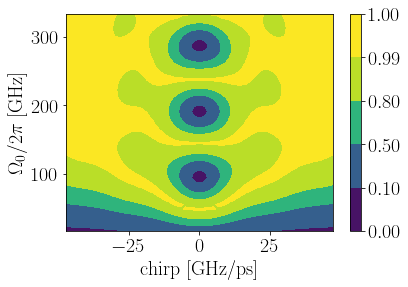

In [50]:
fig,axs = plt.subplots()
contour = axs.contourf(X*1e3/(2*np.pi),Y*1e3/(2*np.pi),final_pops,levels=[0,0.1,0.5,0.80,0.99,1.0])

colorbar = fig.colorbar(contour)
plt.xlabel(r"chirp [GHz/ps]")
plt.ylabel(r"$\Omega_0/2\pi$ [GHz]")
#plt.savefig("./figures/report2/chirp_vs_rabi",bbox_inches="tight")
plt.show()

In [51]:
rabi0 = 2*np.pi*(0.2) # 2pi THz
chirp = 2*np.pi*(32e-3) # 2pi THz/ps


envelope = lambda t: np.exp(-4*np.log(2)*(t-tshift)**2/(pulse_duration**2))
rabi = lambda t, args: rabi0 * envelope(t)    
H_chirp = hbar*qt.Qobj([[0,0],[0,chirp]])
H_transition = 0.5*hbar*qt.sigmax()
H = [[H_chirp,tlist-tlist_shift],[H_transition,rabi]]

result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)


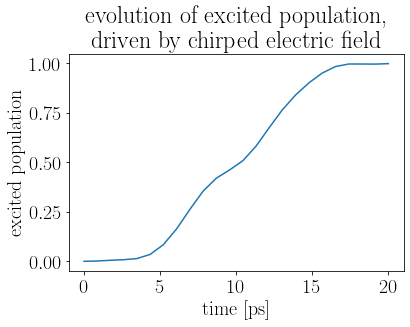

In [55]:
plt.plot(tlist,result.expect[1])
plt.xlabel("time [ps]")
plt.ylabel("excited population")
plt.title("evolution of excited population,\n driven by chirped electric field")
plt.savefig("./figures/report2/chirp",bbox_inches="tight")
plt.show()